Value of objective function: 8.4300287908


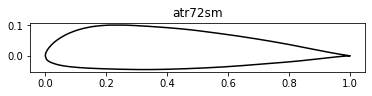

In [2]:
#################################### All the libraries imported are below #################################################
import subprocess as sp
import random
import os
import math
import numpy
import matplotlib.pyplot as plt
from scipy import interpolate
import shutil
from scipy.signal import savgol_filter
###########################################################################################################################

##################################### Defined functions below this ########################################################

# To get airfoil coordinates from xfoil. This can generate NACA 4 or 5 digit series airfoils. 
# air_code is the input variable which is NACA 4 or 5 digit code.
# Saves the coordinates as .txt file.
def get_airfoil(air_code):
    ps = sp.Popen('xfoil.exe', stdin = sp.PIPE)
    s = bytes(f'NACA {air_code}', 'utf-8')
    ps.stdin.write(s + b'\n')
    ps.stdin.write(b'SAVE\n')
    ps.stdin.write(s + b'.txt\n')
    ps.stdin.close()
    ps.wait()
    with open('NACA ' + air_code + '.txt', 'r') as infile: 
        dummy_x, dummy_y = numpy.loadtxt(infile, unpack=True, skiprows=1)
        x = dummy_x.tolist()
        y = dummy_y.tolist()

    return x, y

# Create any number of random digit numbers.
# Input varaiables are n_digits and n_airfoils, n_digits is the number of digits of airfoil code.
# n_airfoils is the number of airfoil codes to be generated.
# It returns a list of airfoil codes.
def rand_digit(n_digits, n_airfoils):
    air_code = []
    for j in range(n_airfoils):
        code = ''
        for i in range(n_digits):
            code += str(random.randint(0, 9))
        air_code.append(code)
    return air_code

#seperate top and bottom half of airfoil.
#x is the x-coordinates of airfoil and y is the y-coordinates of airfoil.
#Returns xu, yu, xl, yl. 
#xu is upper x-coordinates, yu is upper y-coordinates, xl is lower x-coordinates, yl is lower y-coordinates
def seperate_airfoil(x, y):
    count = 0
    for i in range(len(x)-1):
        if x[count + 1] > x[count]:
            count += 1
        else:
            count = 0

    if (count + 1) < len(x):
        if x[0] > x[1]: 
            xu = [x[0]]
            yu = [y[0]]
            xl = []
            yl = []
            for i in range(len(x) - 1):
                if x[i + 1] < x[i]:
                    xu.append(x[i + 1]) 
                    yu.append(y[i + 1])
                else:
                    break
            while i < (len(x) - 1):       
                xl.append(x[i + 1])
                yl.append(y[i + 1])
                i += 1
            yl = [yl for xl, yl in sorted(zip(xl, yl))]
            xl = sorted(xl)
            if (xu[-1] != xl[0]) and (xl[0] != xl[1]):
                xl.insert(0, xu[-1])
                yl.insert(0, yu[-1])
            if xl[0] == xl[1]:
                xl.remove(xl[0])
                yl.remove(yl[0])
            return xu, yu, xl, yl
        else:
            xu = [x[0]]
            yu = [y[0]]
            xl = []
            yl = []
            for i in range(len(x) - 1):
                if x[i + 1] > x[i]:
                    xu.append(x[i + 1]) 
                    yu.append(y[i + 1])
                else:
                    break
            while i < (len(x) - 1):        
                xl.append(x[i + 1])
                yl.append(y[i + 1])
                i += 1
            yl = [yl for xl, yl in sorted(zip(xl, yl))]
            xl = sorted(xl)
            if (xu[0] != xl[0]) and (xl[0] != xl[1]):
                xl.insert(0, xu[0])
                yl.insert(0, yu[0])
            if xl[0] == xl[1]:
                xl.remove(xl[0])
                yl.remove(yl[0])
            if xu[0] < xu[1]:
                xu = list(reversed(xu))
                yu = list(reversed(yu))
            return xu, yu, xl, yl
    else:
        xu = list(reversed(x))
        yu = list(reversed(y))
        xl = x[:]
        yl = y[:]
        return xu, yu, xl, yl

# Obtain extra points by interrpolating spline for given airfoil data from xu, yu, xl, yl.
# Inputs are xu, yu, xl, yl and pts. pts is the number of points required on each half of airfoil (upper and lower).
# Returns new coordinates. new_xu, new_yu, new_xl, new_yl.
def xtra_pts(x, y, pts):
    (xu, yu, xl, yl) = seperate_airfoil(x, y)
    
    yu_sorted = [yu for xu, yu in sorted(zip(xu, yu))]

    yl_sorted = [yl for xl, yl in sorted(zip(xl, yl))]
    
    sp_u = interpolate.PchipInterpolator(sorted(xu), yu_sorted, extrapolate = False)
    sp_l = interpolate.PchipInterpolator(sorted(xl), yl_sorted, extrapolate = False)
    
    theta_u = numpy.linspace(math.pi, 2*math.pi, num = pts, endpoint = True)
    theta_u = theta_u.tolist()
    theta_l = numpy.linspace(0, math.pi, num = pts, endpoint = True)
    theta_l = theta_l.tolist()
    
    new_xu = []
    new_xl = []
    for i in range(len(theta_u)):
        new_xu.append(xu[-1] + (1-(math.cos(theta_u[i])))*((abs(xu[-1]-xu[0]))/2))
    for i in range(len(theta_l)):
        new_xl.append(xl[0] + (1-(math.cos(theta_l[i])))*((abs(xl[-1]-xl[0]))/2))

    new_yu = sp_u(new_xu)
    new_yu = new_yu.tolist()

    new_yl = sp_l(new_xl)
    new_yl = new_yl.tolist()

    if new_xu[-1] == new_xl[0]:
        new_xl = new_xl[1:]
        new_yl = new_yl[1:]
    
    return new_xu, new_yu, new_xl, new_yl

# Saves the coordines x, y into a file
def save_file(x, y, name):
    file = open(name, 'w')
    for i in range(len(x)):
        file.write(str(x[i]) + ' ')
        file.write(str(y[i]) + '\n')
    file.close

# Saves the output of cp after operating on airfoil with given input
def cp_oper(file_name, Re, Mach, N_crit, Alpha):
    ps = sp.Popen('xfoil.exe', stdin = sp.PIPE)
    name_b = bytes(f'{file_name}', 'utf-8')
    Re_b = bytes(f'{Re}', 'utf-8')
    Mach_b = bytes(f'{Mach}', 'utf-8')
    Ncrit_b = bytes(f'{N_crit}', 'utf-8')
    Alpha_b = bytes(f'{Alpha}', 'utf-8')
    ps.stdin.write(b'LOAD\n')
    ps.stdin.write(name_b + b'.dat' + b'\n')
    ps.stdin.write(name_b + b'\n')
    ps.stdin.write(b'PCOP\n')
#     ps.stdin.write(b'N\n')
#     ps.stdin.write(b'200\n')
#     ps.stdin.write(b'\n\n')
    ps.stdin.write(b'OPER\n')
    ps.stdin.write(b'Re\n')
    ps.stdin.write(Re_b + b'\n')
    ps.stdin.write(b'Mach\n')
    ps.stdin.write(Mach_b + b'\n')
    ps.stdin.write(b'VPAR\n')
    ps.stdin.write(b'N\n')
    ps.stdin.write(Ncrit_b + b'\n')
    ps.stdin.write(b'\n')
    ps.stdin.write(b'ALFA\n')
    ps.stdin.write(Alpha_b + b'\n')
    ps.stdin.write(b'CPWR\n')
    ps.stdin.write(b'Cp_' + name_b + b'_(' + Alpha_b + b')' + b'.txt' + b'\n')
    ps.stdin.close()
    ps.wait()

# Saves the output of polars after operating on airfoil with given input 
def polar_oper(file_name, Re, Mach, N_crit, Alpha):
    ps = sp.Popen('xfoil.exe', stdin = sp.PIPE)
    name_b = bytes(f'{file_name}', 'utf-8')
    Re_b = bytes(f'{Re}', 'utf-8')
    Mach_b = bytes(f'{Mach}', 'utf-8')
    Ncrit_b = bytes(f'{N_crit}', 'utf-8')
    Alpha_b = bytes(f'{Alpha}', 'utf-8')
    ps.stdin.write(b'LOAD\n')
    ps.stdin.write(name_b + b'.dat' + b'\n')
    ps.stdin.write(name_b + b'\n')
    ps.stdin.write(b'PPAR\n')
    ps.stdin.write(b'N\n')
    ps.stdin.write(b'200\n')
    ps.stdin.write(b'\n\n')
    ps.stdin.write(b'OPER\n')
    ps.stdin.write(b'Re\n')
    ps.stdin.write(Re_b + b'\n')
    ps.stdin.write(b'Mach\n')
    ps.stdin.write(Mach_b + b'\n')
    ps.stdin.write(b'VPAR\n')
    ps.stdin.write(b'N\n')
    ps.stdin.write(Ncrit_b + b'\n')
    ps.stdin.write(b'\n')
    ps.stdin.write(b'PACC\n')
    ps.stdin.write(b'Polar_' + name_b + b'.txt' + b'\n')
    ps.stdin.write(b'\n')
    ps.stdin.write(b'ALFA\n')
    ps.stdin.write(Alpha_b + b'\n')
    ps.stdin.close()
    ps.wait()


# To copy file from one directory to another
def copy_item(from_path, to_path, item):
    from_path = from_path + item
    to_path = to_path + item
    shutil.copyfile(from_path, to_path)

# Removes unnecessary 
def remove_str(name):
    f=open(name, 'r+', errors='ignore')
    s=f.readlines()
    stror=len(s)
    n=len(s)
    count=0
    i=0
    while (count<n):
        coun=0
        for j in range(len(s[i])):
            if(ord(s[i][j])>58):
                s.remove(s[i])
                coun=1
            if coun==1:
                break
        a1=len(s)
        if(stror==a1):
            i=i+1
        stror=a1
        count=count+1
    f.truncate(0)
    f.seek(0)
    f.writelines(s)
    f.close()

# Extracts the airfoil coordinates from .dat file
def extract_coor(foil):
    remove_str(foil)
    with open(foil, 'r+', errors='ignore') as infile: 
        dummy_x, dummy_y = numpy.loadtxt(infile, unpack=True, skiprows=0)
        x = dummy_x.tolist()
        y = dummy_y.tolist()
    if x[0] > 1:
        x = x[1:]
        y = y[1:]
    return x, y

# Extracts the cp from the output file
def extract_cp(foil):
    remove_str(foil)
    with open(foil, 'r+', errors='ignore') as infile: 
        dummy = numpy.genfromtxt(infile, delimiter=[10,9,9], dtype=None).tolist()
#         dummy_x = dummy_x.tolist()
#         dummy_y = dummy_y.tolist()
        cp = [x[2] for x in dummy]
    return cp

# Plots airfoil with inputs x coordinates, y coordinates and title
def plotting(x, y, title):
    plt.figure()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(title)
    plt.plot(x, y, color = 'black')
    
# def arrange_foil(xu, yu, xl, yl):
    
# Gives new coordinates with inputs airfoil .dat file name and number of points required on top and bottom half of airfoil 
def new_foil(foil, pts):
    (x, y) = extract_coor(foil + '.dat')
    (xu, yu, xl, yl) = xtra_pts(x, y, pts)
    x = xu + xl
    y = yu + yl
    for f in os.listdir(xfoil_path):
        if f == foil + '.dat':
            os.remove(foil + '.dat')
    save_file(x, y, foil + '.dat')
    return x, y

# Gives value of function, with inputs name of airfoil data and target cp
def obj_fun(foil_name, cp_o):
    for f in os.listdir(xfoil_path):
        if f == 'Cp_' + foil_name + '_(' + str(Alpha) + ')' + '.txt':
            os.remove('Cp_' + foil_name + '_(' + str(Alpha) + ')' + '.txt')
    cp_oper(foil_name, Re, Mach, N_crit, Alpha)
    copy_item(xfoil_path, results_path, r'Cp_' + foil_name + r'_(' + str(Alpha) + r')' + r'.txt')
    cp = extract_cp(r'Cp_' + foil_name + r'_(' + str(Alpha) + r')' + r'.txt')
    fun = 0
    for i in range(len(cp)):
        fun = fun + (cp[i] - cp_o[i])**2
    return fun

###########################################################################################################################

################################################### INPUTS ################################################################
pts = 100 #number of points to create
Re = 200000 #Reynolds number
Mach = 0 #Mach number
N_crit = 8.1 #Critical boundary layer interaction
Alpha = 0 #Angle of attack

# Change the path according to your system
database_path = r'C:\Users\X\Downloads\Xfoil6.99_Python\Database\\'
xfoil_path = r'C:\Users\X\Downloads\Xfoil6.99_Python\\'
results_path = r'C:\Users\X\Downloads\Xfoil6.99_Python\Results\\'

# Target cp
t_cp = r'Cp_' + 'new_ag25' + r'_(' + str(Alpha) + r')' + r'.txt' 
###########################################################################################################################

#################################################### THE CODE #############################################################
for i in range(1):    
    # Copy airfoil data from database
    data_base = [f for f in os.listdir(database_path) if (f.endswith(".dat")) or (f.endswith(".DAT"))]
    foil = random.choice(data_base)
    copy_item(database_path, xfoil_path, foil)
    foil = foil[0:-4] # Remove .dat extension
    
    cp_o = extract_cp(t_cp) # Extract target cp
    
    # Get new coordinates for airfoil
    (new_x, new_y) = new_foil(foil, pts)

    # Plot the new coordinates of airfoil
    plotting(new_x, new_y, foil)
    
    # Get cp by operating on the new airfoil coordinates through xfoil
    fun = obj_fun(foil, cp_o)
    print(f'Value of objective function: {fun}')

###########################################################################################################################

############################################# REMOVING UNNECESSARY FILES ##################################################
os.remove(foil + '.dat')
# os.remove('new_' + foil + '.dat')
os.remove('Cp_' + foil + '_(' + str(Alpha) + ')' + '.txt')
###########################################################################################################################


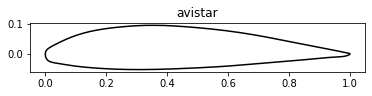

In [43]:

#xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx Functions defined for optimization, Needs optimization! xxxxxxxxxxxxxxxxxxxxxxxxxxxxx#
# Needs improvement, don't worry about it now.
def rand_foil(x, y, i):
    rand_y = (rand_neigh(y[i], 0.1))
    y[i] = rand_y
    (rand_yu, rand_yl) = spline_pts(x, y)
    rand_y = y
    for f in os.listdir(xfoil_path):
        if f == 'rand_' + foil + '.dat':
            os.remove('rand_' + foil + '.dat')
    save_file(x, rand_y, 'rand_'+ foil + '.dat')
    return x, rand_y

def rand_neigh(y, fac):
    if random.randint(0, 1) == 1:
        #n_x = x + random.random()*fac
        n_y = y + random.random()*fac
    else:
        #n_x = x - random.random()*fac
        n_y = y - random.random()*fac
    return n_y

# Gives smoothed coordinates from given coordinates
def spline_pts(new_x, rand_y):
    (xu, yu, xl, yl) = seperate_airfoil(new_x, rand_y)
    
    new_yu = savgol_filter(yu, 51, 3)
    new_yu = new_yu.tolist()

    new_yl = savgol_filter(yl, 51, 3)
    new_yl = new_yl.tolist()

    r_li_y = []
    #r_li_x = []
    for i in range(len(new_yu)):
        if math.isnan(new_yu[i]):
            r_li_y.append(new_yu[i])
            #r_li_x.append(new_xu[i])
    for i in range(len(r_li_y)):
       # new_xu.remove(r_li_x[i])
        new_yu.remove(r_li_y[i])

    r_li_y = []
    #r_li_x = []
    for i in range(len(new_yl)):
        if math.isnan(new_yl[i]):
            r_li_y.append(new_yl[i])
           # r_li_x.append(new_xd[i])
    for i in range(len(r_li_y)):
       # new_xd.remove(r_li_x[i])
        new_yl.remove(r_li_y[i])
    return new_yu, new_yl
#xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx#

#xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx TRIED OPTIMIZATION xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx#
#fun = obj_fun('new_' + foil, cp_o)

# for j in range(len(new_x)):
#     #Problem variables
#     x_ii = new_x[j]
#     y_ii = new_y[j]
#     t_factor = 0.5

#     #Search factor
#     k = 1

#     #Initializing T
#     x_i = x_ii
#     y_i = y_ii
#     Ts = []
#     for i in range(4):
        
#         (new_x, rand_y) = rand_foil(new_x, new_y, j)
#         Ts.append(obj_fun('rand_'+ foil, cp_o))
        
#         T = sum(Ts)/len(Ts)
#     print(T)

#     #Simulated Annealing

#     #Initializing random point in the neighbourhood of initial point
    
#     (new_x, rand_y) = rand_foil(new_x, new_y, j)
#     x_n = new_x[j] 
#     y_n = rand_y[j]

#     #Initial distance between points
#     dif = ((x_n - x_i)**2 + (y_n - y_i)**2)**0.5

#     #Creating a list of good points and its function values
#     good_li = [(x_ii, y_ii)]
#     good_fu = [obj_fun('rand_'+ foil, cp_o)]
    

#     dif = ((x_n - x_i)**2 + (y_n - y_i)**2)**0.5
#     while (dif > 0.01) or ((x_n, y_n) == (x_ii, y_ii)):
#         n = 0
#         while n < 100: #n factor
#             del_E = obj_fun('rand_'+ foil, cp_o) - obj_fun('new_' + foil, cp_o)
#             if del_E < 0:
#                 dif = ((x_n - x_i)**2 + (y_n - y_i)**2)**0.5
#                 x_i = x_n
#                 y_i = y_n
#                 good_li.append((x_i, y_i))
#                 good_fu.append(obj_fun('rand_'+ foil, cp_o))
                
#                 (new_x, rand_y) = rand_foil(new_x, rand_y, j)
#                 x_n = new_x[j] 
#                 y_n = rand_y[j]
            
#             elif (del_E > 0) and (T != 0):
#                 p = boltz_prob(del_E, T)
#                 if prob_deci(p) == 1:
#                     dif = ((x_n - x_i)**2 + (y_n - y_i)**2)**0.5
#                     x_i = x_n
#                     y_i = y_n
#                     good_li.append((x_i, y_i))
#                     good_fu.append(obj_fun('rand_'+ foil, cp_o))
                    
#                     (new_x, rand_y) = rand_foil(new_x, rand_y, j)
#                     x_n = new_x[j] 
#                     y_n = rand_y[j]
#                 else:
#                     dif = ((x_n - x_i)**2 + (y_n - y_i)**2)**0.5
#                     (x_n, y_n) = good_li[good_fu.index(min(good_fu))]

#             else:
#                 dif = ((x_n - x_i)**2 + (y_n - y_i)**2)**0.5
#                 (x_n, y_n) = good_li[good_fu.index(min(good_fu))]
            
#             n += 1    
#         T = t_factor*T
#     print(j)
#     rand_y[j] = y_i


# rand_foil(new_x, new_y, 1)
# rand_fun = obj_fun('rand_'+ foil, cp_o)
# print(fun, rand_fun)

# plotting(new_x, rand_y, 'rand_' + foil)
#xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx#
